<a href="https://colab.research.google.com/github/Srirama-Gollanavar/AI_ML/blob/main/Stock_price_trend_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-5-2074612777.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_symbol, start='2015-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 0.0157
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0015
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0011
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0012
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0010
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 8.6115e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 7.3350e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 7.9075e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 7.6838e-04
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 9.1070e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
RMSE: 9.06


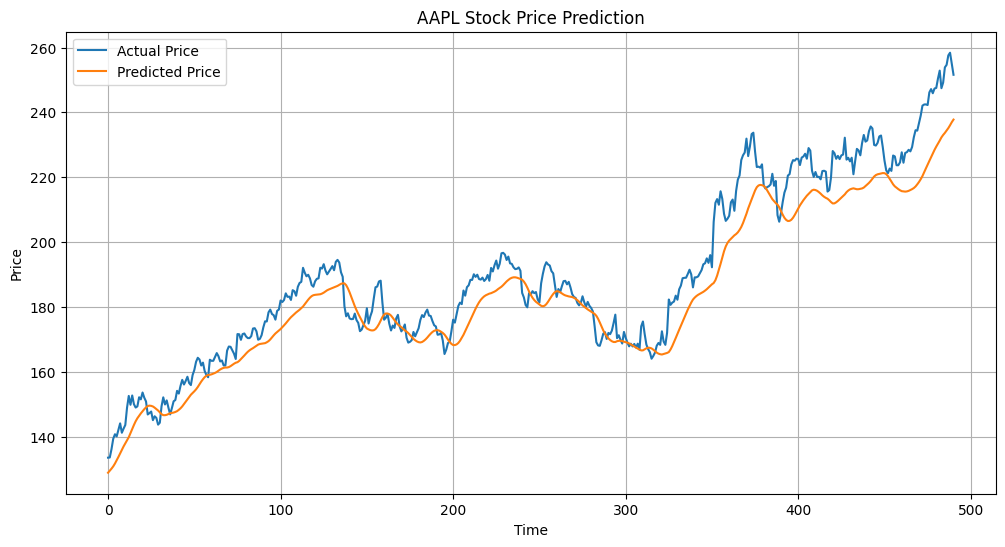

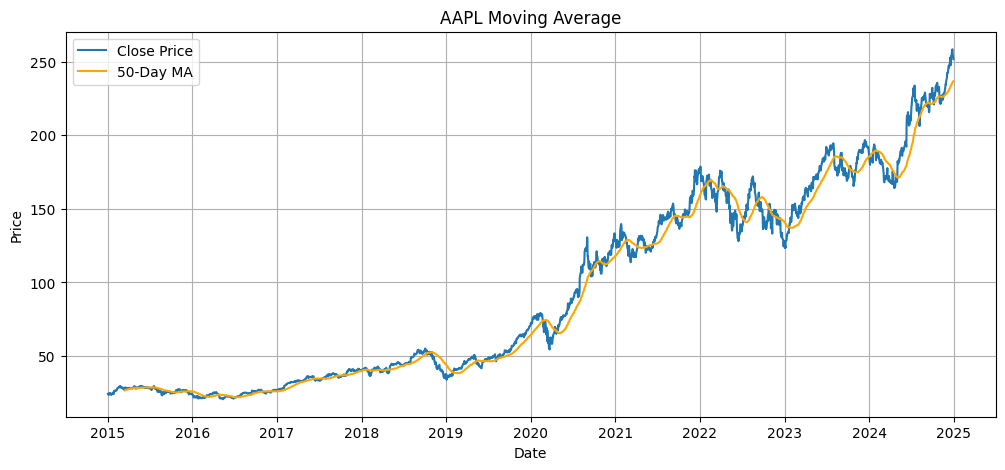

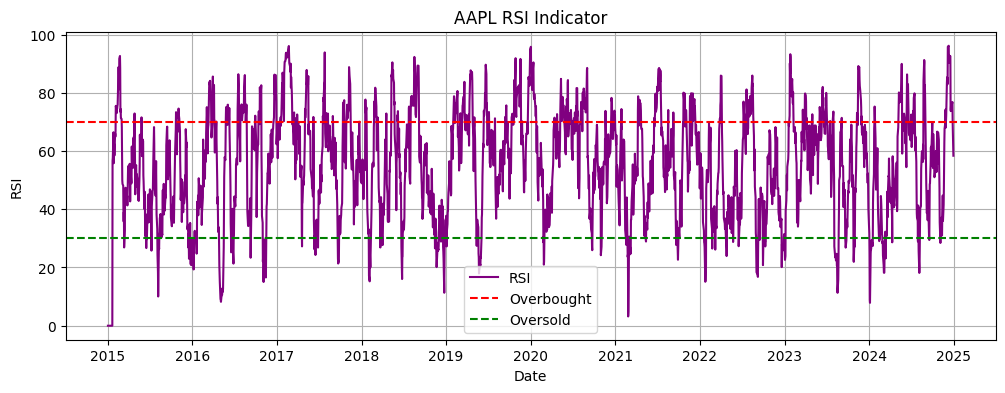

 Model saved as 'lstm_model.h5'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
 Predicted next closing price: $238.29


In [5]:


import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

stock_symbol = 'AAPL'
df = yf.download(stock_symbol, start='2015-01-01', end='2024-12-31')
df = df[['Close']].dropna()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(scaled_data, seq_len)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f'RMSE: {rmse:.2f}')

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

df['MA50'] = df['Close'].rolling(window=50).mean()


def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(0)

df['RSI'] = compute_RSI(df)

plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA50'], label='50-Day MA', color='orange')
plt.title(f'{stock_symbol} Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='green', linestyle='--', label='Oversold')
plt.title(f'{stock_symbol} RSI Indicator')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.show()

model.save("lstm_model.h5")
print(" Model saved as 'lstm_model.h5'")

last_sequence = scaled_data[-seq_len:].reshape((1, seq_len, 1))
next_price_scaled = model.predict(last_sequence)
next_price = scaler.inverse_transform(next_price_scaled)
print(f" Predicted next closing price: ${next_price[0][0]:.2f}")
